In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# test
# Load the CSV data into a DataFrame
df = pd.read_csv('eth_transactions_cropped.csv')

# Display the first 5 rows of the DataFrame
print(df.head())

   Unnamed: 0                                               hash  nonce  \
0           0  0xa611438e5637c227e5080477b7180fc3d1c76710f2aa...     14   
1           1  0xd5d2fe97f1fa4b772476e208f1e9a3441a0f54a020ac...      3   
2           2  0xc93e15158aa51a4d9a93c3c153868c8c89f4545c3445...     19   
3           3  0x454bc286bda9cf62a43730e465df8e76c23124d6dde7...     17   
4           4  0xba053083f0752cd5f9a152105698dba490d5992b9839...    993   

   transaction_index                                from_address  \
0                 41  0x506a48155c891c78c04bc0b70eb1d9b2361635e0   
1                 59  0x544c7de319b72b557a0c1fafccf5202813f9f3f7   
2                 76  0x1562c07b34b828cedaadda6959a0b1362103b7b4   
3                 83  0x0afaec415159835aab6d56fbc6a22e1d60c76c45   
4                 90  0x7bd8477901552199e8208f62875aa94fab2fffb3   

                                   to_address         value     gas  \
0  0x7cc46cf6392ed9db45351a3f82eb2cc3b83da761  0.000000e+00  157911  

## EDA (Exploratory Data Analysis)

In [3]:
print(df.shape)
print(df.columns)

(9999, 22)
Index(['Unnamed: 0', 'hash', 'nonce', 'transaction_index', 'from_address',
       'to_address', 'value', 'gas', 'gas_price', 'input',
       'receipt_cumulative_gas_used', 'receipt_gas_used',
       'receipt_contract_address', 'receipt_root', 'receipt_status',
       'block_timestamp', 'block_number', 'block_hash', 'max_fee_per_gas',
       'max_priority_fee_per_gas', 'transaction_type',
       'receipt_effective_gas_price'],
      dtype='object')


# About our Data

<p>
Unnamed: 0: This is likely an index column from the original dataset. It doesn't carry any meaningful information for our analysis.

hash: This is the unique identifier of the transaction.

nonce: This is a value that can only be used once. It's used to prevent the same transaction from being processed more than once.

transaction_index: This is the position of the transaction in the block.

from_address: This is the address of the sender of the transaction.

to_address: This is the address of the receiver of the transaction.

value: This is the amount of Ether being transferred in the transaction.

gas: This is the amount of "gas" provided for the transaction. Gas in Ethereum is the measure of computational effort.

gas_price: This is the price of gas in Gwei (1 Gwei = 1e-9 Ether) set by the sender of the transaction.

input: This is an optional data field that can be included in a transaction. It's used when the transaction is sent to a smart contract.

receipt_cumulative_gas_used: This is the total amount of gas used in the block when this transaction was processed.

receipt_gas_used: This is the amount of gas used by this particular transaction.

receipt_contract_address: If the transaction was a contract creation, this is the address of the created contract.

receipt_status: This is the status of the transaction - '1' means the transaction was successful, and '0' means it failed.

block_hash: This is the unique identifier of the block that includes this transaction.

block_number: This is the number of the block that includes this transaction.

block_timestamp: This is the timestamp of when the block was mined.
</p>

In [4]:
print(df.isnull().sum())

Unnamed: 0                        0
hash                              0
nonce                             0
transaction_index                 0
from_address                      0
to_address                        7
value                             0
gas                               0
gas_price                         0
input                             0
receipt_cumulative_gas_used       0
receipt_gas_used                  0
receipt_contract_address       9992
receipt_root                   9999
receipt_status                    0
block_timestamp                   0
block_number                      0
block_hash                        0
max_fee_per_gas                2093
max_priority_fee_per_gas       2093
transaction_type                  0
receipt_effective_gas_price       0
dtype: int64


In [5]:
print(df.describe())

        Unnamed: 0         nonce  transaction_index         value  \
count  9999.000000  9.999000e+03        9999.000000  9.999000e+03   
mean   4999.000000  3.555542e+05          84.870687  3.686360e+17   
std    2886.607005  1.421843e+06          53.525997  7.034252e+18   
min       0.000000  0.000000e+00           0.000000  0.000000e+00   
25%    2499.500000  6.000000e+00          40.000000  0.000000e+00   
50%    4999.000000  1.090000e+02          81.000000  7.929801e+14   
75%    7498.500000  3.207500e+03         124.000000  2.101168e+16   
max    9998.000000  4.564810e+07         287.000000  5.365026e+20   

                gas     gas_price  receipt_cumulative_gas_used  \
count  9.999000e+03  9.999000e+03                 9.999000e+03   
mean   1.583855e+05  1.430050e+10                 6.416255e+06   
std    5.235348e+05  4.890215e+10                 5.277260e+06   
min    2.100000e+04  9.483132e+09                 2.100000e+04   
25%    2.100000e+04  1.161922e+10               

/tmp/ipykernel_61907/2336973428.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


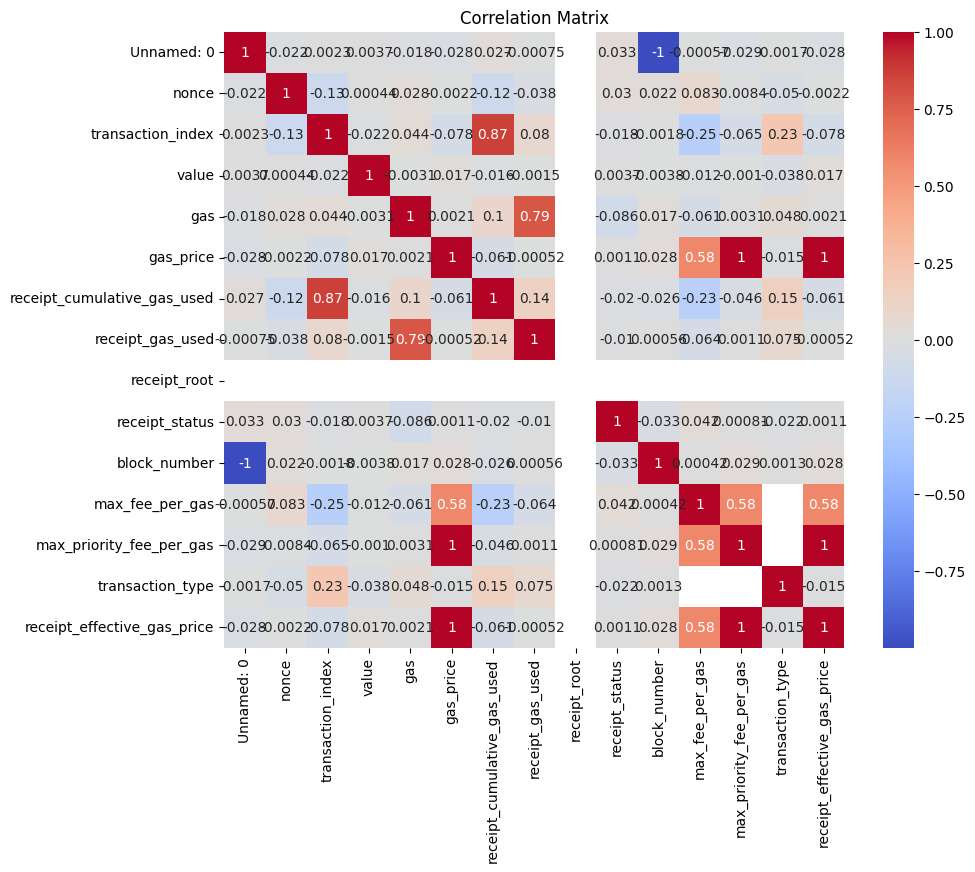

In [6]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Strong Positive Correlation:
Values close to +1 imply a strong positive correlation. This means that as one variable increases, the other variable also increases. For example, a correlation of +0.8 or higher is typically considered strong.

Strong Negative Correlation:
Values close to -1 indicate a strong negative correlation. This means that as one variable increases, the other decreases. Similarly, a correlation of -0.8 or lower is often considered strong in the negative direction.
No Correlation:

A value close to 0 implies no correlation. This means there is no linear relationship between the two variables.


## Data Cleaning Process

In [7]:
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0','receipt_root']
df = df.drop(columns=columns_to_drop)

In [8]:
# Handle missing values - Since the 'to_address' column has missing values, we fill them with a placeholder 
# (Ethereum transactions to a null address are typically contract creation transactions)
df['to_address'] = df['to_address'].fillna('ContractCreation')

In [9]:
# handle receipt_contract_address missing values
df['receipt_contract_address'] = df['receipt_contract_address'].fillna('Unknown address')

In [10]:
# handle max_priority_fee_per_gas missing values
df['max_fee_per_gas'].fillna(df['max_fee_per_gas'].mean(), inplace=True)
df['max_priority_fee_per_gas'].fillna(df['max_priority_fee_per_gas'].mean(), inplace=True)

In [11]:
print(df.isnull().sum())

hash                           0
nonce                          0
transaction_index              0
from_address                   0
to_address                     0
value                          0
gas                            0
gas_price                      0
input                          0
receipt_cumulative_gas_used    0
receipt_gas_used               0
receipt_contract_address       0
receipt_status                 0
block_timestamp                0
block_number                   0
block_hash                     0
max_fee_per_gas                0
max_priority_fee_per_gas       0
transaction_type               0
receipt_effective_gas_price    0
dtype: int64


In [12]:
df.head()

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
0,0xa611438e5637c227e5080477b7180fc3d1c76710f2aa...,14,41,0x506a48155c891c78c04bc0b70eb1d9b2361635e0,0x7cc46cf6392ed9db45351a3f82eb2cc3b83da761,0.000000e+00,157911,12618483129,0xa0712d68000000000000000000000000000000000000...,2727153,100474,Unknown address,1,2022-12-04 17:56:23+00:00,16113072,0x2dded46570b4cf879e0083e7f37a9169061075965dfd...,2.362667e+10,2.500000e+09,2,12618483129
1,0xd5d2fe97f1fa4b772476e208f1e9a3441a0f54a020ac...,3,59,0x544c7de319b72b557a0c1fafccf5202813f9f3f7,0xf89d7b9c864f589bbf53a82105107622b35eaa40,1.708352e+15,21000,12118483129,0x,4348316,21000,Unknown address,1,2022-12-04 17:56:23+00:00,16113072,0x2dded46570b4cf879e0083e7f37a9169061075965dfd...,2.000000e+11,2.000000e+09,2,12118483129
2,0xc93e15158aa51a4d9a93c3c153868c8c89f4545c3445...,19,76,0x1562c07b34b828cedaadda6959a0b1362103b7b4,0x7dbfed48bddd2d4357f1f3c7dc45f5f85eb7100e,1.240000e+17,21000,11618483129,0x,5206151,21000,Unknown address,1,2022-12-04 17:56:23+00:00,16113072,0x2dded46570b4cf879e0083e7f37a9169061075965dfd...,1.601040e+10,1.500000e+09,2,11618483129
3,0x454bc286bda9cf62a43730e465df8e76c23124d6dde7...,17,83,0x0afaec415159835aab6d56fbc6a22e1d60c76c45,0x6448d7a20ece8c57212ad52b362b5c9b4feac27d,3.300000e+17,176364,11618483129,0x7649b957000000000000000000000000000000000000...,6065201,111434,Unknown address,1,2022-12-04 17:56:23+00:00,16113072,0x2dded46570b4cf879e0083e7f37a9169061075965dfd...,1.601040e+10,1.500000e+09,2,11618483129
4,0xba053083f0752cd5f9a152105698dba490d5992b9839...,993,90,0x7bd8477901552199e8208f62875aa94fab2fffb3,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0.000000e+00,212432,11618483129,0x5ae401dc000000000000000000000000000000000000...,6620399,152899,Unknown address,1,2022-12-04 17:56:23+00:00,16113072,0x2dded46570b4cf879e0083e7f37a9169061075965dfd...,1.576050e+10,1.500000e+09,2,11618483129


In [13]:
# Convert the 'block_timestamp' to datetime
df['block_timestamp'] = pd.to_datetime(df['block_timestamp'])

### Transaction Flow Analysis: 

Using from_address and to_address, we can analyze transaction flows, identifying common senders and receivers, and understanding the network of transactions.

In [14]:
# Number of unique addresses
unique_from_addresses = df['from_address'].nunique()
unique_to_addresses = df['to_address'].nunique()

print("unique_from_addresses",unique_from_addresses)
print("unique_to_addresses",unique_to_addresses)

unique_from_addresses 5810
unique_to_addresses 3545


# which addreses appear to sent more than others

In [15]:
print(df['from_address'].value_counts().head(10))

0x1be210e7990eff6c07cb8cadcb9d077063ac3614    445
0x28c6c06298d514db089934071355e5743bf21d60     88
0xdfd5293d8e347dfe59e90efd55b2956a1343963d     86
0x46340b20830761efd32832a74d7169b29feb9758     85
0x21a31ee1afc51d94c2efccaa2092ad1028285549     85
0xa9831d89c4067bf7518efbcb6351ef6dd0059f33     79
0x56eddb7aa87536c09ccc2793473599fd21a8b17f     60
0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7     54
0xadd2a3c46055792acfa1f2973e18ffed85dcc55e     52
0x9696f59e4d72e237be84ffd425dcad154bf96976     50
Name: from_address, dtype: int64


# Top 10 popular addresses to receive

In [16]:
print(df['to_address'].value_counts().head(10))

0xf89d7b9c864f589bbf53a82105107622b35eaa40    852
0xdac17f958d2ee523a2206206994597c13d831ec7    778
0x7492e30d60d96c58ed0f0dc2fe536098c620c4c0    425
0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45    421
0x00000000006c3852cbef3e08e8df289169ede581    285
0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48    230
0xeeeec6476073778077b40a73fe32e23a9876cab4    198
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2    163
0x06450dee7fd2fb8e39061434babcfc05599a6fb8    139
0x7a250d5630b4cf539739df2c5dacb4c659f2488d    124
Name: to_address, dtype: int64


In [13]:
# Graph
# import networkx as nx


# top_5_senders = df['from_address'].value_counts().head(5).index
# top_5_receivers = df['to_address'].value_counts().head(5).index

# # Filtering the data to include only transactions involving these top addresses
# simplified_data = df[(df['from_address'].isin(top_5_senders)) | (df['to_address'].isin(top_5_receivers))]

# # Creating a simplified network graph
# G_simplified = nx.DiGraph()

# for _, row in simplified_data.iterrows():
#     G_simplified.add_edge(row['from_address'], row['to_address'], weight=row['value'])

# plt.figure(figsize=(10, 10))
# pos_simplified = nx.spring_layout(G_simplified, seed=42)  # for consistent layout
# nx.draw_networkx(G_simplified, pos_simplified, node_size=700, node_color='lightblue', alpha=0.8, arrows=True)
# plt.title('Simplified Transaction Flow Among Top Ethereum Addresses')
# plt.show()

# When?

## Temporal Patterns: 

Here, we'll plot the number of transactions over time, looking for hourly or minute patterns.

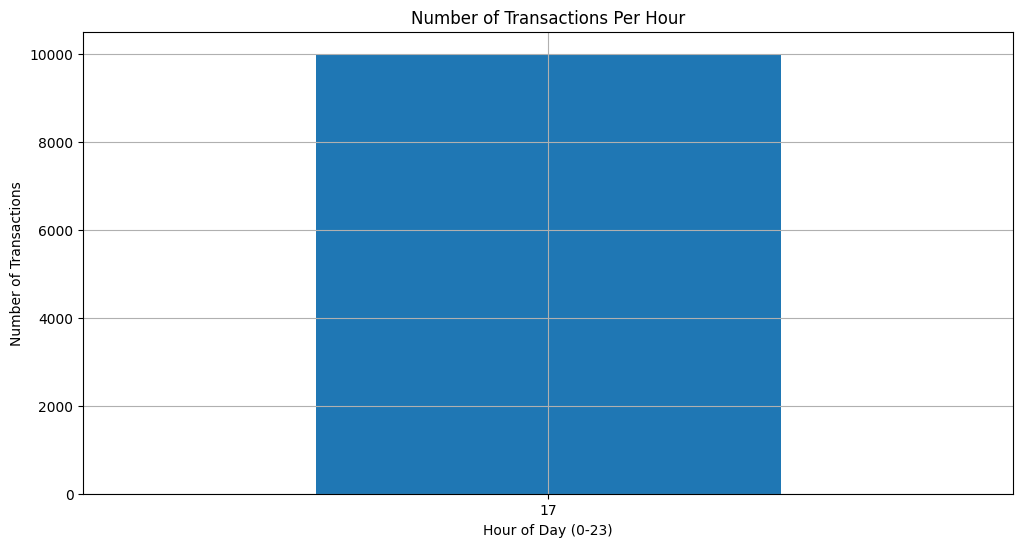

In [17]:
# Temporal Patterns: Analyzing transaction counts by hour

# Extracting hour from the timestamp
df['hour'] = df['block_timestamp'].dt.hour

# Grouping data by hour to count transactions
transaction_counts_by_hour = df.groupby('hour').size()

# Plotting the number of transactions per hour
plt.figure(figsize=(12, 6))
transaction_counts_by_hour.plot(kind='bar')
plt.title('Number of Transactions Per Hour')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

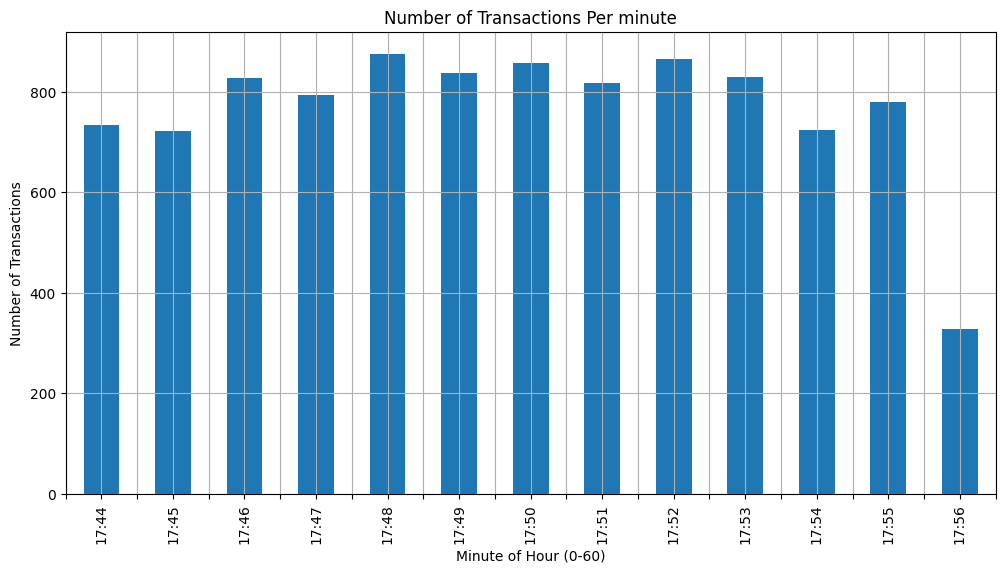

In [18]:
# Temporal Patterns: Analyzing transaction counts by minute
from matplotlib.ticker import MaxNLocator

# Extracting hour from the timestamp
# Extracting minute and hour from the timestamp for more granular analysis
df['minute_of_hour'] = df['block_timestamp'].dt.minute
df['hour_of_day'] = df['block_timestamp'].dt.hour

# Combining date, hour, and minute for a unique time identifier
df['date_hour_minute'] =  df['hour_of_day'].astype(str) + ':' + df['minute_of_hour'].astype(str)


# Grouping data by hour to count transactions
transaction_counts_by_hour = df.groupby('date_hour_minute').size()

# Plotting the number of transactions per hour
plt.figure(figsize=(12, 6))
transaction_counts_by_hour.plot(kind='bar')
plt.title('Number of Transactions Per minute')
plt.xlabel('Minute of Hour (0-60)')
plt.ylabel('Number of Transactions')

# Customizing the x-axis labels
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(MaxNLocator(nbins=30)) # Adjust 'nbins' as needed


plt.xticks(rotation=90)
plt.grid(True)
plt.show()

## Gas and Transaction Efficiency: 

We can visualize the distribution of gas used and gas prices, as well as how they change over time.

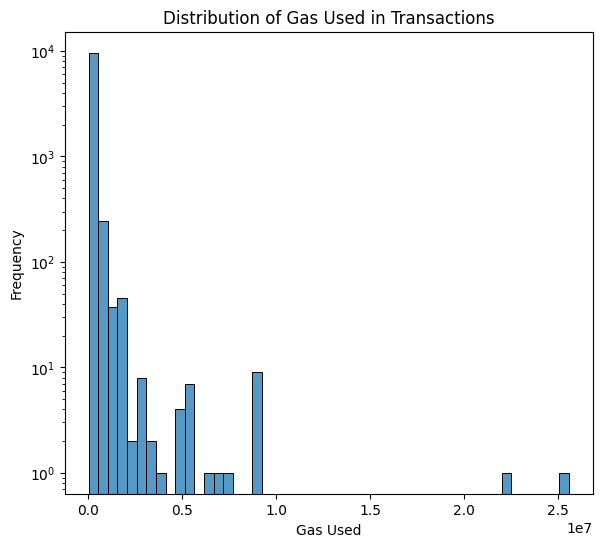

In [19]:
# Distribution of Gas Used
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['gas'], bins=50, kde=False)
plt.title('Distribution of Gas Used in Transactions')
plt.xlabel('Gas Used')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale due to wide range of values

By visualizing the distribution of gas used in transactions, we can identify the typical range of gas consumption. This can help us understand the average complexity of transactions on the Ethereum network. Unusually high gas consumption may indicate complex smart contract interactions or inefficient transaction practices.

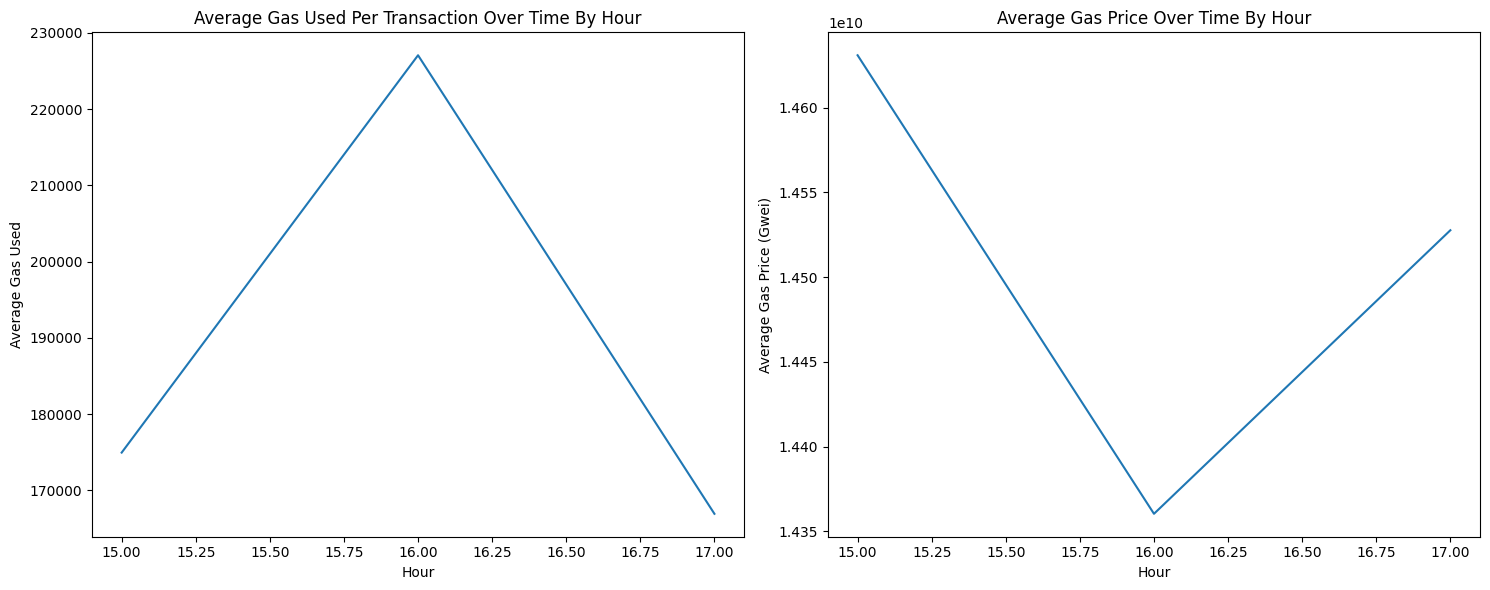

In [19]:
# Visualizing how Gas Used and Gas Prices change over time
# For simplicity, we will use the average values per hour
df['hour'] = df['block_timestamp'].dt.hour
avg_gas_by_day = df.groupby('hour')['gas'].mean()
avg_gas_price_by_day = df.groupby('hour')['gas_price'].mean()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
avg_gas_by_day.plot(kind='line')
plt.title('Average Gas Used Per Transaction Over Time By Hour')
plt.xlabel('Hour')
plt.ylabel('Average Gas Used')

plt.subplot(1, 2, 2)
avg_gas_price_by_day.plot(kind='line')
plt.title('Average Gas Price Over Time By Hour')
plt.xlabel('Hour')
plt.ylabel('Average Gas Price (Gwei)')

plt.tight_layout()
plt.show()

We can identify periods of congestion or low activity based on fluctuations in gas prices. High gas prices may indicate network congestion and increased demand for transaction processing, while low gas prices may suggest periods of low activity.

Correlation between Gas Price and Gas Used:

Analyzing the relationship between gas prices and gas used in transactions can help us understand user behavior and network dynamics. For example, we might observe that users are willing to pay higher gas prices for transactions with larger gas consumption, indicating a willingness to prioritize more complex or high-value transactions during periods of congestion.

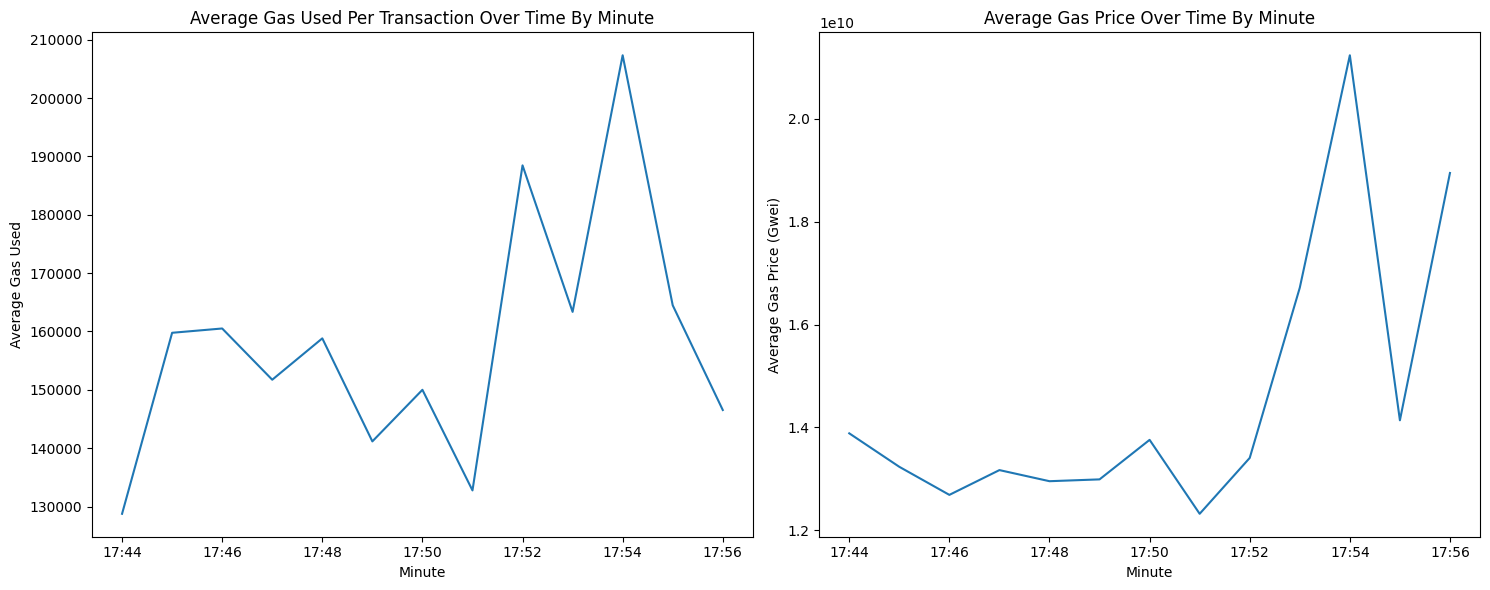

In [20]:
# For simplicity, we will use the average values per minute

# Extracting hour from the timestamp
# Extracting minute and hour from the timestamp for more granular analysis
df['minute_of_hour'] = df['block_timestamp'].dt.minute
df['hour_of_day'] = df['block_timestamp'].dt.hour

# Combining date, hour, and minute for a unique time identifier
df['date_hour_minute'] =  df['hour_of_day'].astype(str) + ':' + df['minute_of_hour'].astype(str)



avg_gas_by_day = df.groupby('date_hour_minute')['gas'].mean()
avg_gas_price_by_day = df.groupby('date_hour_minute')['gas_price'].mean()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
avg_gas_by_day.plot(kind='line')
plt.title('Average Gas Used Per Transaction Over Time By Minute')
plt.xlabel('Minute')
plt.ylabel('Average Gas Used')

plt.subplot(1, 2, 2)
avg_gas_price_by_day.plot(kind='line')
plt.title('Average Gas Price Over Time By Minute')
plt.xlabel('Minute')
plt.ylabel('Average Gas Price (Gwei)')

plt.tight_layout()
plt.show()

Average Gas Used Per Transaction by Minute:

</br>

This line chart shows the average gas used in transactions for each minute within an hour. While minute-to-minute variations might be more subtle, this chart can still highlight any short-term fluctuations in gas usage, potentially revealing finer-grained patterns or anomalies.

Average Gas Price by Minute:

</br>

This chart illustrates the average gas price (in Gwei) for each minute within an hour. Like the gas usage, minute-level variations might be less pronounced but can still provide insights into very short-term pricing dynamics.

## Smart Contract Interactions: 

</br>
We'll visualize the proportion of transactions that interact with smart contracts.

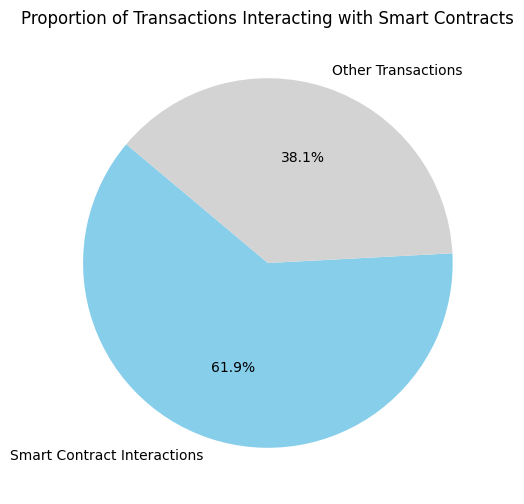

In [21]:
# Smart Contract Interactions: Visualizing the proportion of transactions interacting with smart contracts

# Identifying transactions with non-empty 'input' field as smart contract interactions
df['is_smart_contract_interaction'] = df['input'].apply(lambda x: x != '0x')

# Calculating the proportion of transactions that are smart contract interactions
smart_contract_interaction_proportion = df['is_smart_contract_interaction'].mean()

# Visualizing the proportion
plt.figure(figsize=(8, 6))
plt.pie([smart_contract_interaction_proportion, 1 - smart_contract_interaction_proportion], 
        labels=['Smart Contract Interactions', 'Other Transactions'], 
        autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
plt.title('Proportion of Transactions Interacting with Smart Contracts')
plt.show()

Insights:

Usage of Smart Contracts: The chart provides a clear view of how prevalent smart contract interactions are in the Ethereum network. A larger segment for smart contract interactions would indicate a significant use of Ethereum for more than just Ether transfers, highlighting its role as a platform for decentralized applications.

Network Activity Composition: Understanding the proportion of smart contract interactions can give insights into the composition of network activity, which is crucial for both users and developers. It helps in gauging the network's complexity and the demand for computational resources.

## Contract Creation Activity: 

We can plot the number of new contracts created over time.

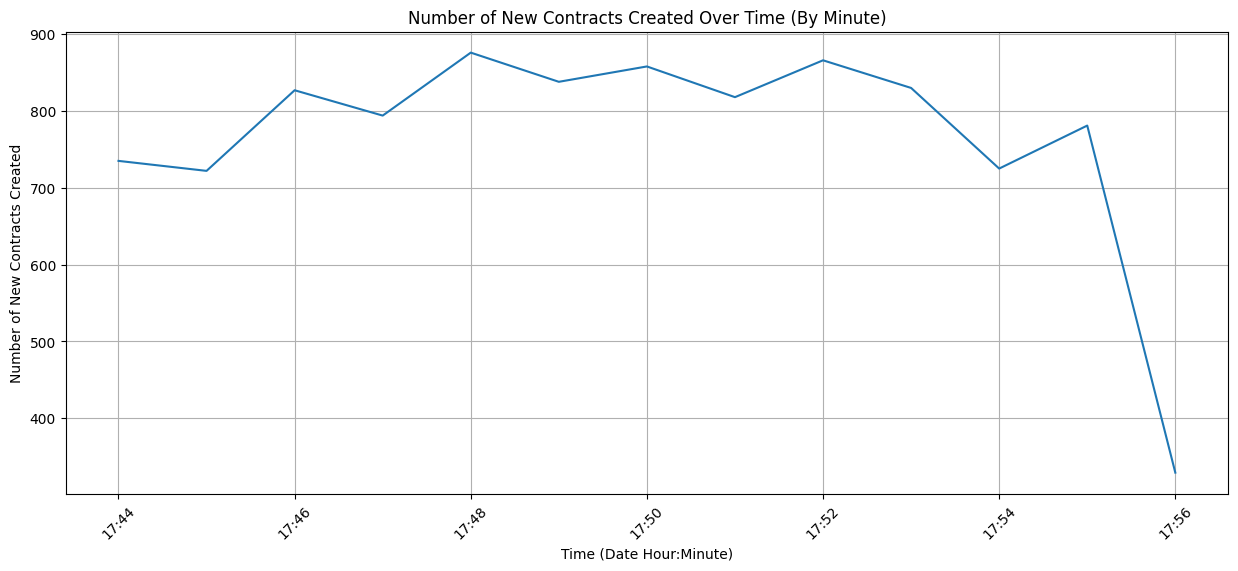

In [22]:
# Contract Creation Activity: Plotting the number of new contracts created by minute
df['is_contract_creation'] = df['receipt_contract_address'].notna()

# Extracting minute and hour from the timestamp for more granular analysis
df['minute_of_hour'] = df['block_timestamp'].dt.minute
df['hour_of_day'] = df['block_timestamp'].dt.hour

# Combining date, hour, and minute for a unique time identifier
df['date_hour_minute'] =  df['hour_of_day'].astype(str) + ':' + df['minute_of_hour'].astype(str)

# Grouping data by this unique time identifier to count new contract creations
contract_creation_counts_minute = df.groupby('date_hour_minute')['is_contract_creation'].sum()

# Plotting the number of new contracts created by minute
# Note: This will be a large plot, so we'll limit it to a subset of the data
sampled_contract_creation_counts_minute = contract_creation_counts_minute.head(1000)

plt.figure(figsize=(15, 6))
sampled_contract_creation_counts_minute.plot(kind='line')
plt.title('Number of New Contracts Created Over Time (By Minute)')
plt.xlabel('Time (Date Hour:Minute)')
plt.ylabel('Number of New Contracts Created')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Insights:
Granular View of Contract Creation: Plotting the data by minute offers a granular view of contract creation activity. This can reveal short-term spikes or patterns that might be related to specific events or periods of high activity.

High-Frequency Fluctuations: Unlike daily or hourly aggregations, minute-level data can exhibit more fluctuations, reflecting the immediacy of activities on the network.

Potential for Anomaly Detection: This level of detail can be useful for detecting anomalies or unusual bursts of activity, which might be indicative of specific events or trends in the developer community.

Limitations of Minute-Level Analysis: It's important to note that such fine-grained analysis may sometimes yield noisy data, making it challenging to discern clear trends. Additionally, the plot covers only a small portion of the entire dataset due to its size and complexity.

## Transaction Success and Failures: 

The receipt_status column is crucial for understanding the reliability of the network. Analyzing the proportion of successful vs. failed transactions, and identifying patterns or common reasons for failures can be insightful.

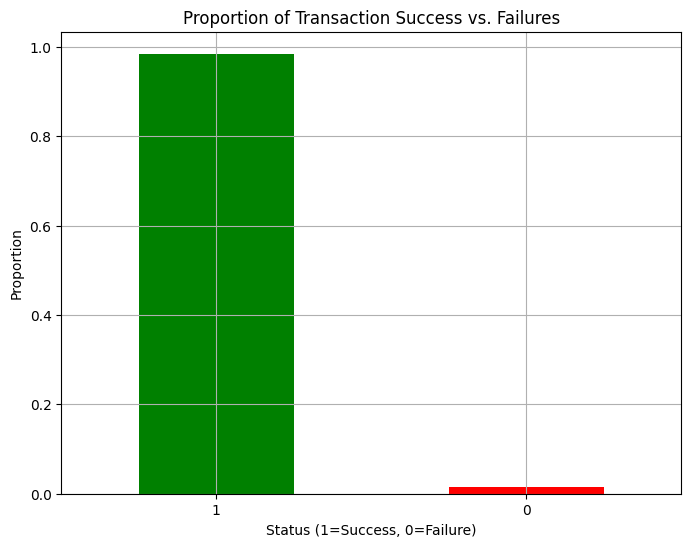

In [23]:
# Transaction Success and Failures: Visualizing the proportion of successful and failed transactions
# Calculating the proportion of transaction statuses
transaction_success_proportion = df['receipt_status'].value_counts(normalize=True)

# Visualizing the proportion
plt.figure(figsize=(8, 6))
transaction_success_proportion.plot(kind='bar', color=['green', 'red'])
plt.title('Proportion of Transaction Success vs. Failures')
plt.xlabel('Status (1=Success, 0=Failure)')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

## Insights:
Network Reliability: The chart provides a clear indication of the Ethereum network's reliability. A high proportion of successful transactions suggests a stable and reliable network.

Impact of Network Conditions: The rate of failed transactions can be influenced by network conditions. For example, during times of high congestion or rapid changes in gas prices, the rate of failures might increase.

User Experience: The ratio of successes to failures can also reflect the user experience. A lower rate of failures implies that users are generally able to execute their transactions without issues.

Optimization Opportunities: For developers and network operators, understanding the proportion of failed transactions can help in identifying areas for optimization and improvement within the network or in user interfaces.

## Block-Level Analysis: 

We'll visualize the number of transactions per block and other related block-level metrics.

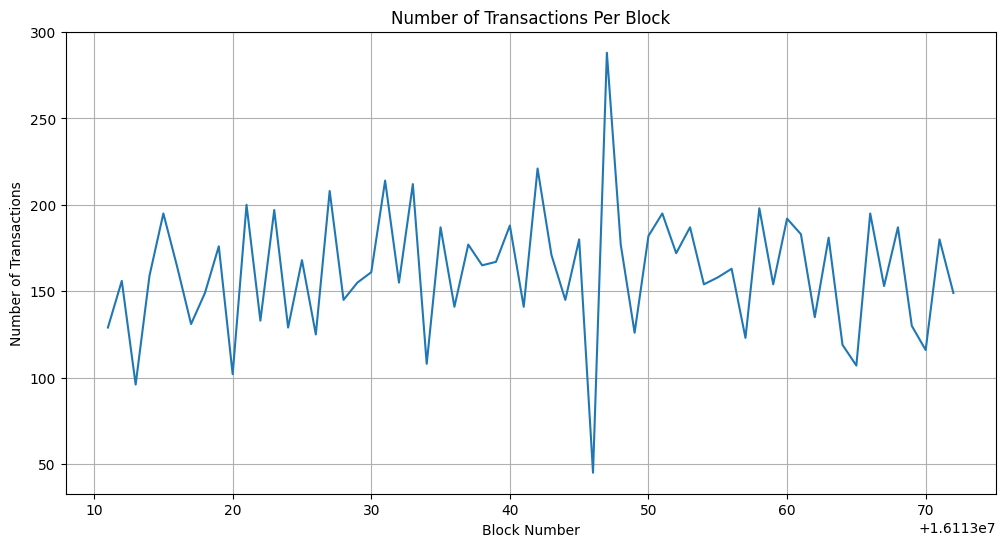

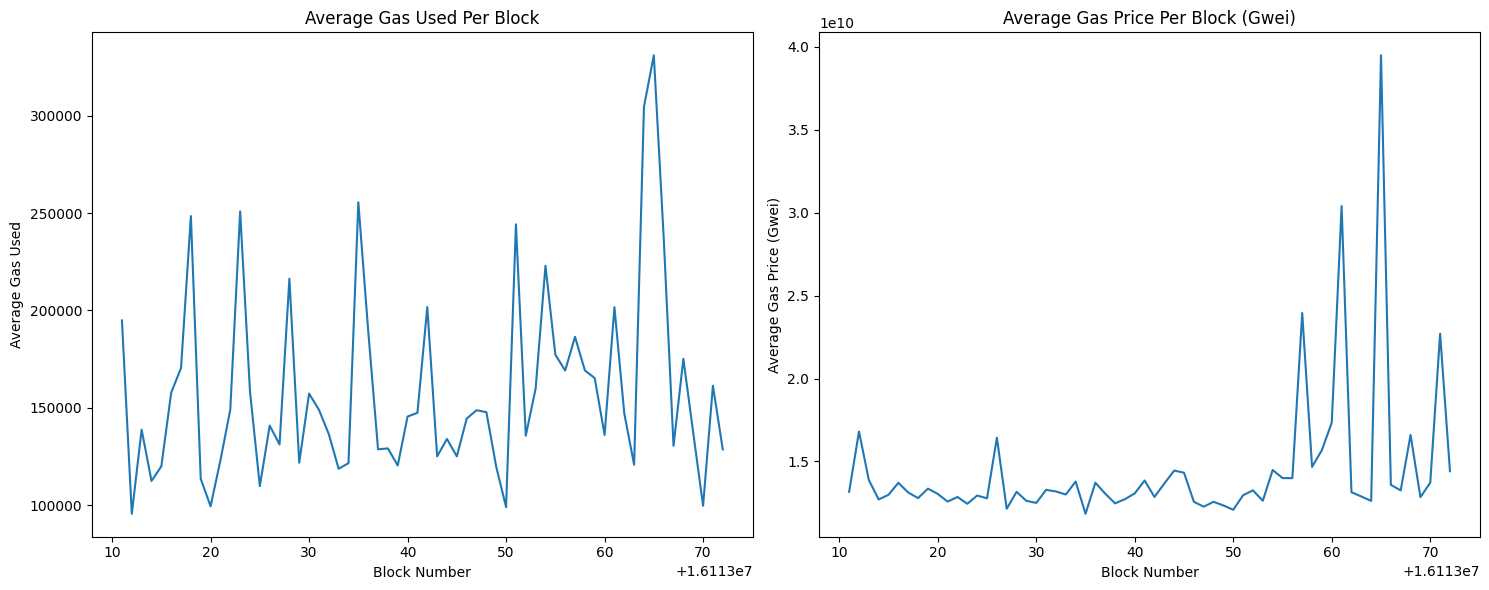

In [24]:
# Block-Level Analysis: Visualizing the number of transactions per block and other related block-level metrics

# Counting the number of transactions per block
transactions_per_block = df.groupby('block_number').size()

# Visualizing the number of transactions per block
plt.figure(figsize=(12, 6))
transactions_per_block.plot(kind='line')
plt.title('Number of Transactions Per Block')
plt.xlabel('Block Number')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

# Calculating additional block-level metrics such as average gas used and average gas price per block
avg_gas_per_block = df.groupby('block_number')['gas'].mean()
avg_gas_price_per_block = df.groupby('block_number')['gas_price'].mean()

# Visualizing these metrics
plt.figure(figsize=(15, 6))

# Average Gas Used Per Block
plt.subplot(1, 2, 1)
avg_gas_per_block.plot(kind='line')
plt.title('Average Gas Used Per Block')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Used')

# Average Gas Price Per Block
plt.subplot(1, 2, 2)
avg_gas_price_per_block.plot(kind='line')
plt.title('Average Gas Price Per Block (Gwei)')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Price (Gwei)')

plt.tight_layout()
plt.show()


### Insights:
Block Utilization Trends: Understanding the number of transactions per block is crucial for assessing the Ethereum network's capacity and efficiency. It also helps in gauging the scalability of the network.

Resource Usage Patterns: The average gas used per block reflects the network's resource usage patterns. Blocks consistently using high amounts of gas might indicate a need for optimization or scaling solutions.

Gas Price Dynamics: The average gas price per block can provide insights into the economic aspects of the Ethereum network, particularly how users respond to changes in network demand.

# Which addresses have the highest average

In [25]:
# Average transaction value per sender address
average_value_per_sender = df.groupby('from_address')['value'].mean()

# Top 10 sender addresses with the highest average transaction value
top_value_senders = average_value_per_sender.sort_values(ascending=False).head(10)

(top_value_senders)

from_address
0x2ba994a0511093a0b93e8094d1f4c025cef0211d    5.365026e+20
0x6fc48de8f167456b7aa27dd4ecfabba329ea623d    2.044285e+20
0x86ce119ccebcc254d62c335c97afe1ba2a697aef    1.851914e+20
0x6c8ee01f1f8b62e987b3d18f6f28b22a0ada755f    1.200000e+20
0x60dc740cd5cf4f5087f6cf1aeecf8c3c698ff4b7    1.136236e+20
0x7974b46e7940de2c4d6458c053bdbac0bf111683    7.000000e+19
0x2211ed0f73daa4c97b403dd12b7e28da59852dac    4.000000e+19
0x7a749b759d8e9e9f34433994868fb035217ab65d    2.500000e+19
0x78e83b0e05fa3c8caa5d589fd35b1dabdf1edd91    2.445484e+19
0x3f2bf39c9d63b29912c44efc5cfff85cf4699665    2.200000e+19
Name: value, dtype: float64

In [26]:
# Average transaction value per receiver address
average_value_per_receiver = df.groupby('to_address')['value'].mean()
# Top 10 receiver addresses with the highest average transaction value
top_value_receivers = average_value_per_receiver.sort_values(ascending=False).head(10)
(top_value_receivers)

to_address
0x0016c0d0343e8f2c3a7b6a51606b84b1545ec606    3.250631e+20
0x7ea871c9343df09034ec580f63ae56118ab8dd48    2.129570e+20
0x52f21fceacd9e35ad6d782c9ecdeacb4a4919e6e    1.959000e+20
0x86afef8d914f83722139dc0a9f557186fada02ce    1.851914e+20
0xb1ed4a9662fd2ccee652ba266c847088b67087f8    9.606658e+19
0x221e675d25321b3fa1574401cf8ad5483b11af98    5.586084e+19
0x0d095a0b3b89621508a520c15388ace20599ce68    5.000000e+19
0x943319b22490f93555c53f72f3aa9e31219d99f4    4.000000e+19
0x970e24aa00befcdf0ad09178312ff450016caf66    3.516600e+19
0xb17fe9f5a2b3e016c653e101845121421e2b225a    2.445484e+19
Name: value, dtype: float64

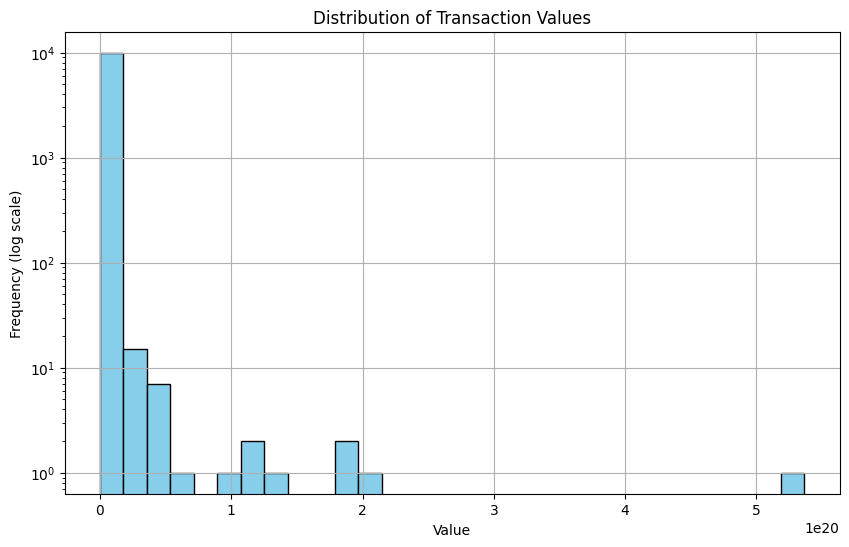

count    9.999000e+03
mean     3.686360e+17
std      7.034252e+18
min      0.000000e+00
25%      0.000000e+00
50%      7.929801e+14
75%      2.101168e+16
max      5.365026e+20
Name: value, dtype: float64

In [27]:
# Descriptive statistics for the 'value' column
value_description = df['value'].describe()

# Distribution of the transaction 'value'
plt.figure(figsize=(10, 6))
plt.hist(df['value'], bins=30, log=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Transaction Values')
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()

(value_description)

# For reference ethereum price was 3,510.33$ at the time 

So 5.36 * 3,510.33 is approximately 18.815$

In [28]:
df.head()

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,hour,minute_of_hour,hour_of_day,date_hour_minute,is_smart_contract_interaction,is_contract_creation
0,0xa611438e5637c227e5080477b7180fc3d1c76710f2aa...,14,41,0x506a48155c891c78c04bc0b70eb1d9b2361635e0,0x7cc46cf6392ed9db45351a3f82eb2cc3b83da761,0.000000e+00,157911,12618483129,0xa0712d68000000000000000000000000000000000000...,2727153,...,2.362667e+10,2.500000e+09,2,12618483129,17,56,17,17:56,True,True
1,0xd5d2fe97f1fa4b772476e208f1e9a3441a0f54a020ac...,3,59,0x544c7de319b72b557a0c1fafccf5202813f9f3f7,0xf89d7b9c864f589bbf53a82105107622b35eaa40,1.708352e+15,21000,12118483129,0x,4348316,...,2.000000e+11,2.000000e+09,2,12118483129,17,56,17,17:56,False,True
2,0xc93e15158aa51a4d9a93c3c153868c8c89f4545c3445...,19,76,0x1562c07b34b828cedaadda6959a0b1362103b7b4,0x7dbfed48bddd2d4357f1f3c7dc45f5f85eb7100e,1.240000e+17,21000,11618483129,0x,5206151,...,1.601040e+10,1.500000e+09,2,11618483129,17,56,17,17:56,False,True
3,0x454bc286bda9cf62a43730e465df8e76c23124d6dde7...,17,83,0x0afaec415159835aab6d56fbc6a22e1d60c76c45,0x6448d7a20ece8c57212ad52b362b5c9b4feac27d,3.300000e+17,176364,11618483129,0x7649b957000000000000000000000000000000000000...,6065201,...,1.601040e+10,1.500000e+09,2,11618483129,17,56,17,17:56,True,True
4,0xba053083f0752cd5f9a152105698dba490d5992b9839...,993,90,0x7bd8477901552199e8208f62875aa94fab2fffb3,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0.000000e+00,212432,11618483129,0x5ae401dc000000000000000000000000000000000000...,6620399,...,1.576050e+10,1.500000e+09,2,11618483129,17,56,17,17:56,True,True


<br/>
<br/>

### The distribution of transaction values is highly skewed, with most transactions having low values. This is common in financial data, where a large number of transactions are for small amounts, and a small number of transactions are for large amounts.

<br/>
<br/>


# Feature Engineering

hour_of_day: This represents the hour of the day (in 24-hour format) when the block containing the transaction was added to the blockchain.

day_of_week: This represents the day of the week (Monday=0, Sunday=6) when the block containing the transaction was added to the blockchain.

month: This represents the months when the block containing the transaction was added to the blockchain.
    
year: This represents the hour of the year when the block containing the transaction was added to the blockchain.
    
total_transactions_sender: This represents the total number of transactions made by the sender address in the dataset.

total_transactions_receiver: This represents the total number of transactions received by the receiver address in the dataset.

average_value_sender: This represents the average value of transactions made by the sender address in the dataset.

average_value_receiver: This represents the average value of transactions received by the receiver address in the dataset.

In [29]:
# Create time-based features
df['hour_of_day'] = df['block_timestamp'].dt.hour
df['minute'] = df['block_timestamp'].dt.minute
df['day_of_week'] = df['block_timestamp'].dt.dayofweek
df['month'] = df['block_timestamp'].dt.month
df['year'] = df['block_timestamp'].dt.year

# Total transactions made by each sender address
total_transactions_sender = df.groupby('from_address').size()
df['total_transactions_sender'] = df['from_address'].map(total_transactions_sender)

# Total transactions received by each receiver address
total_transactions_receiver = df.groupby('to_address').size()
df['total_transactions_receiver'] = df['to_address'].map(total_transactions_receiver)

# Average value of transactions made by each sender address
average_value_sender = df.groupby('from_address')['value'].mean()
df['average_value_sender'] = df['from_address'].map(average_value_sender)

# Average value of transactions received by each receiver address
average_value_receiver = df.groupby('to_address')['value'].mean()
df['average_value_receiver'] = df['to_address'].map(average_value_receiver)



df.head()

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,is_smart_contract_interaction,is_contract_creation,minute,day_of_week,month,year,total_transactions_sender,total_transactions_receiver,average_value_sender,average_value_receiver
0,0xa611438e5637c227e5080477b7180fc3d1c76710f2aa...,14,41,0x506a48155c891c78c04bc0b70eb1d9b2361635e0,0x7cc46cf6392ed9db45351a3f82eb2cc3b83da761,0.000000e+00,157911,12618483129,0xa0712d68000000000000000000000000000000000000...,2727153,...,True,True,56,6,12,2022,4,1,1.750000e+16,0.000000e+00
1,0xd5d2fe97f1fa4b772476e208f1e9a3441a0f54a020ac...,3,59,0x544c7de319b72b557a0c1fafccf5202813f9f3f7,0xf89d7b9c864f589bbf53a82105107622b35eaa40,1.708352e+15,21000,12118483129,0x,4348316,...,False,True,56,6,12,2022,1,852,1.708352e+15,8.165083e+15
2,0xc93e15158aa51a4d9a93c3c153868c8c89f4545c3445...,19,76,0x1562c07b34b828cedaadda6959a0b1362103b7b4,0x7dbfed48bddd2d4357f1f3c7dc45f5f85eb7100e,1.240000e+17,21000,11618483129,0x,5206151,...,False,True,56,6,12,2022,1,1,1.240000e+17,1.240000e+17
3,0x454bc286bda9cf62a43730e465df8e76c23124d6dde7...,17,83,0x0afaec415159835aab6d56fbc6a22e1d60c76c45,0x6448d7a20ece8c57212ad52b362b5c9b4feac27d,3.300000e+17,176364,11618483129,0x7649b957000000000000000000000000000000000000...,6065201,...,True,True,56,6,12,2022,1,8,3.300000e+17,8.736862e+16
4,0xba053083f0752cd5f9a152105698dba490d5992b9839...,993,90,0x7bd8477901552199e8208f62875aa94fab2fffb3,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0.000000e+00,212432,11618483129,0x5ae401dc000000000000000000000000000000000000...,6620399,...,True,True,56,6,12,2022,3,421,3.333333e+17,3.564572e+17


### From Address Metrics ( Aggregation):

Average Transaction Value: The mean value of Ether transferred in transactions for each address on each day.

Average Gas Used: The mean amount of gas used in transactions for each address on each day.

Average Gas Price: The mean price of gas (in Gwei) set by transactions for each address on each day.

Total Transactions: The total number of transactions sent from each address on each day.

Total Value Sent: The total amount of Ether sent from each address on each day.

In [30]:
# Aggregating by day for 'from_address'
address_hour_agg = df.groupby(['from_address', 'date_hour_minute']).agg(
    average_transaction_value=('value', 'mean'),
    average_gas_used=('gas', 'mean'),
    average_gas_price=('gas_price', 'mean'),
    total_transactions=('hash', 'count'),
    total_value_sent=('value', 'sum')
)

# Displaying the first few rows of the aggregated data
address_hour_agg.head(10)

average_transaction_value  \
from_address                               date_hour_minute                              
0x00000000863b56a3c1f0f1be8bc4f8b7bd78f57a 17:47                          0.000000e+00   
                                           17:49                          0.000000e+00   
0x0000000e4d1c13209896e1c3de920305f66ad059 17:56                          3.883000e+16   
0x0002b5ca4da0bf9b22480a39c32145159388baed 17:47                          2.000000e+17   
                                           17:49                          2.000000e+17   
                                           17:51                          1.948516e+17   
0x00032550944ee9b1a050796fc9074011b2f2c28f 17:54                          1.000000e+17   
0x000715880d00126d99a5494029cdfa6249d355f8 17:55                          0.000000e+00   
0x000f422887ea7d370ff31173fd3b46c8f66a5b1c 17:46                          9.915587e+16   
                                           17:47                          3.582579e+16   

                                                             average_gas_used  \
from_address                               date_hour_minute                     
0x00000000863b56a3c1f0f1be8bc4f8b7bd78f57a 17:47                     300000.0   
                                           17:49                     103380.0   
0x0000000e4d1c13209896e1c3de920305f66ad059 17:56                      21000.0   
0x0002b5ca4da0bf9b22480a39c32145159388baed 17:47                     191383.0   
                                           17:49                     188859.0   
                                           17:51                     241490.0   
0x00032550944ee9b1a050796fc9074011b2f2c28f 17:54                      92151.0   
0x000715880d00126d99a5494029cdfa6249d355f8 17:55                      69145.0   
0x000f422887ea7d370ff31173fd3b46c8f66a5b1c 17:46                      50000.0   
                                           17:47                      50000.0   

                                                             average_gas_price  \
from_address                               date_hour_minute                      
0x00000000863b56a3c1f0f1be8bc4f8b7bd78f57a 17:47                  1.878702e+10   
                                           17:49                  1.196266e+10   
0x0000000e4d1c13209896e1c3de920305f66ad059 17:56                  1.161848e+10   
0x0002b5ca4da0bf9b22480a39c32145159388baed 17:47                  1.192608e+10   
                                           17:49                  1.161922e+10   
                                           17:51                  1.157178e+10   
0x00032550944ee9b1a050796fc9074011b2f2c28f 17:54                  1.191350e+10   
0x000715880d00126d99a5494029cdfa6249d355f8 17:55                  1.270798e+10   
0x000f422887ea7d370ff31173fd3b46c8f66a5b1c 17:46                  1.318690e+10   
                                           17:47                  1.408312e+10   

                                                             total_transactions  \
from_address                               date_hour_minute                       
0x00000000863b56a3c1f0f1be8bc4f8b7bd78f57a 17:47                              1   
                                           17:49                              1   
0x0000000e4d1c13209896e1c3de920305f66ad059 17:56                              1   
0x0002b5ca4da0bf9b22480a39c32145159388baed 17:47                              1   
                                           17:49                              1   
                                           17:51                              1   
0x00032550944ee9b1a050796fc9074011b2f2c28f 17:54                              1   
0x000715880d00126d99a5494029cdfa6249d355f8 17:55                              1   
0x000f422887ea7d370ff31173fd3b46c8f66a5b1c 17:46                              1   
                                           17:47                              1   

                         

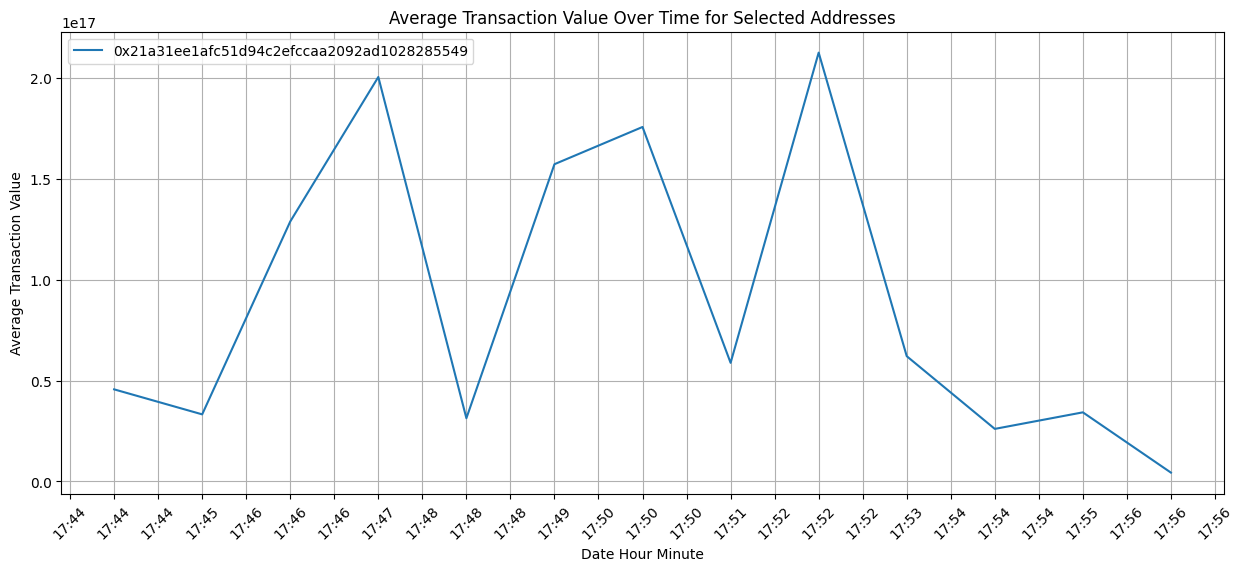

In [31]:
# Placeholder addresses for demonstration
selected_addresses = ['0x21a31ee1afc51d94c2efccaa2092ad1028285549' ]  
# Replace with actual addresses

plt.figure(figsize=(15, 6))

for address in selected_addresses:
    # Filtering the data for the selected address
    address_data = address_hour_agg.loc[address]

    # Plotting average transaction value over time
    plt.plot(address_data.index, address_data['average_transaction_value'], label=address)

plt.xlabel('Date Hour Minute')
plt.ylabel('Average Transaction Value')
plt.title('Average Transaction Value Over Time for Selected Addresses')
plt.legend()
plt.grid(True)

# Customizing the x-axis labels
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(MaxNLocator(nbins=30)) # Adjust 'nbins' as needed


plt.xticks(rotation=45)
plt.show()


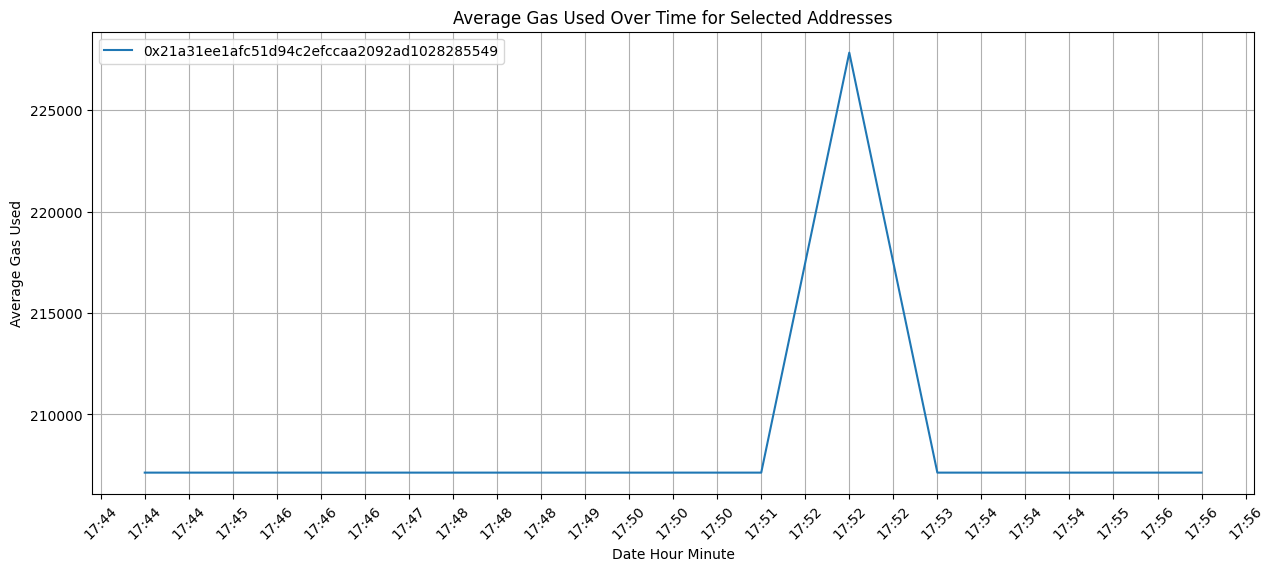

In [32]:
plt.figure(figsize=(15, 6))

for address in selected_addresses:
    # Filtering the data for the selected address
    address_data = address_hour_agg.loc[address]

    # Plotting average transaction value over time
    plt.plot(address_data.index, address_data['average_gas_used'], label=address)

plt.xlabel('Date Hour Minute')
plt.ylabel('Average Gas Used')
plt.title('Average Gas Used Over Time for Selected Addresses')
plt.legend()
plt.grid(True)

# Customizing the x-axis labels
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(MaxNLocator(nbins=30)) # Adjust 'nbins' as needed


plt.xticks(rotation=45)
plt.show()

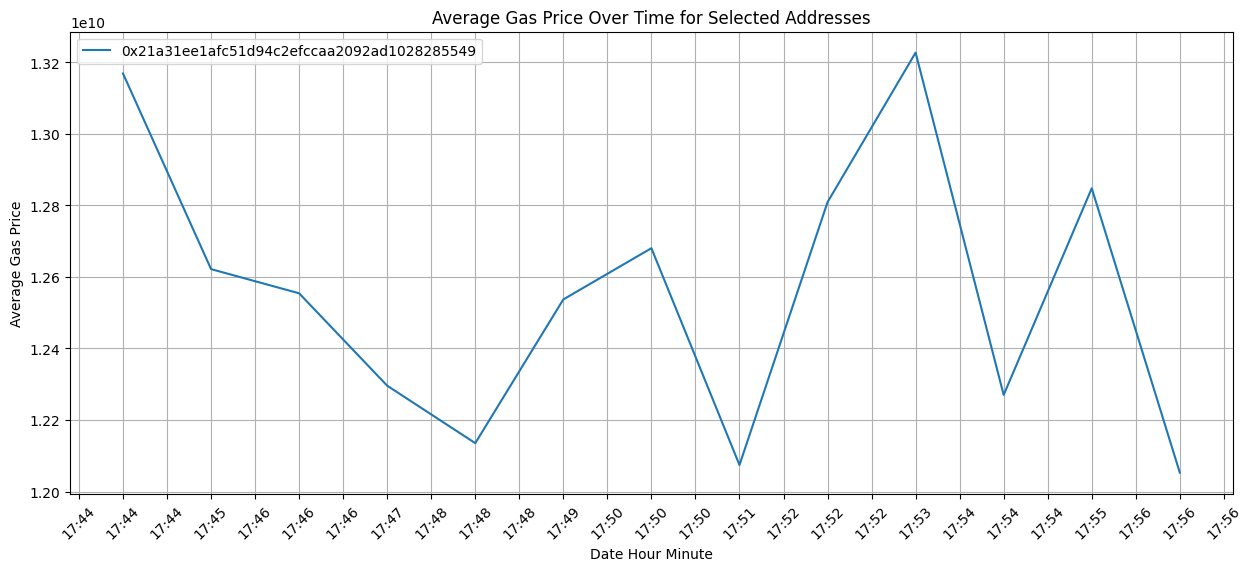

In [33]:
plt.figure(figsize=(15, 6))

for address in selected_addresses:
    # Filtering the data for the selected address
    address_data = address_hour_agg.loc[address]

    # Plotting average transaction value over time
    plt.plot(address_data.index, address_data['average_gas_price'], label=address)

plt.xlabel('Date Hour Minute')
plt.ylabel('Average Gas Price')
plt.title('Average Gas Price Over Time for Selected Addresses')
plt.legend()
plt.grid(True)

# Customizing the x-axis labels
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(MaxNLocator(nbins=30)) # Adjust 'nbins' as needed


plt.xticks(rotation=45)
plt.show()


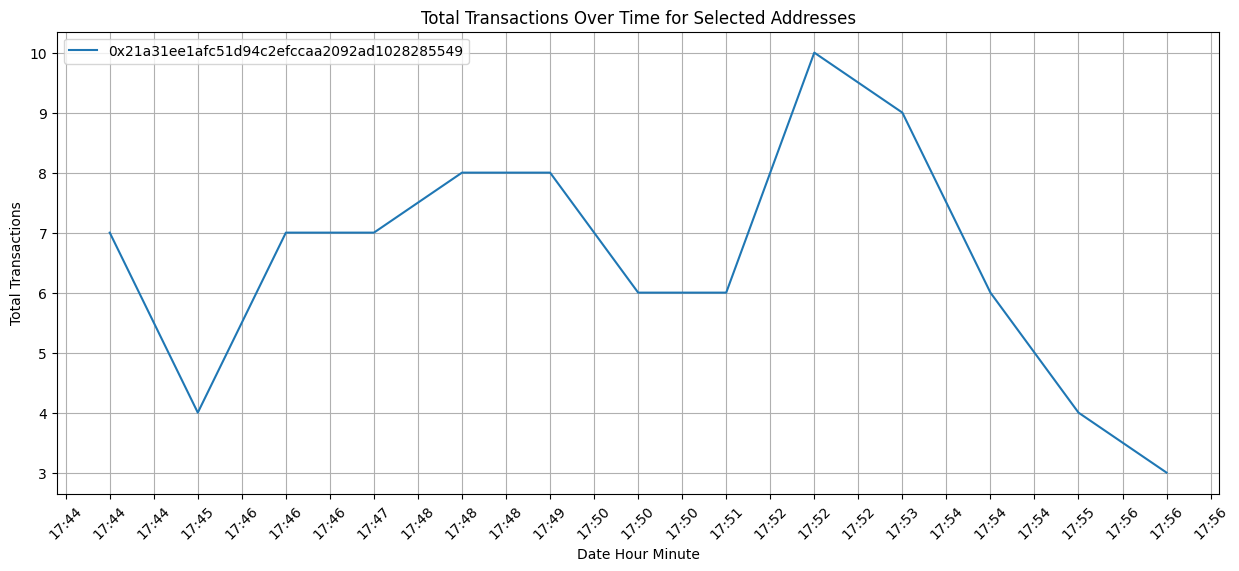

In [34]:
plt.figure(figsize=(15, 6))

for address in selected_addresses:
    # Filtering the data for the selected address
    address_data = address_hour_agg.loc[address]

    # Plotting average transaction value over time
    plt.plot(address_data.index, address_data['total_transactions'], label=address)

plt.xlabel('Date Hour Minute')
plt.ylabel('Total Transactions')
plt.title('Total Transactions Over Time for Selected Addresses')
plt.legend()
plt.grid(True)

# Customizing the x-axis labels
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(MaxNLocator(nbins=30)) # Adjust 'nbins' as needed


plt.xticks(rotation=45)
plt.show()


Time series plots of transaction metrics can provide several insights useful for anomaly detection, especially when observing metrics like average transaction value, gas used, and gas prices over time. Here are some key insights you might derive:

Sudden Spikes or Drops: Sharp increases or decreases in transaction values, gas used, or gas prices can indicate anomalous activity. For instance, a sudden spike in transaction value might suggest large transfers that are not typical for the address.

Outliers: Points that deviate significantly from the general pattern could be potential outliers. These might be transactions that are unusually high or low compared to the normal activity of the address.

Pattern Changes: Anomalies might be indicated by changes in the usual patterns of activity. For example, if an address consistently shows low transaction values and suddenly starts transacting in high values, it could be considered anomalous.

Periodicity and Trends: Regular patterns like cyclical activity or trends (upward or downward) can be normal for some addresses. A break from these patterns could signal something unusual.

Consistency with Known Events: If there are known market events or network changes (like Ethereum upgrades), see if the anomalies align with these events. Anomalies that coincide with such events might be explainable and not necessarily indicative of suspicious activity.

Comparison Across Addresses: If you're observing multiple addresses, anomalies might also be identified by comparing their activities. An address behaving distinctly from others in a similar category could be flagged for further investigation.

## Pick an algorithm:

- we will go with Isolation Forest or K-means or DBSCAN, ideally all

## Training

# K-MEANS

In [35]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import numpy as np

# Assuming 'df' is your DataFrame and the features are selected
features = df[['hour_of_day', 'day_of_week', 'month', 'year', 'total_transactions_sender', 'total_transactions_receiver', 'average_value_sender', 'average_value_receiver']]

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features.fillna(0))  # Handling nulls by replacing them with 0

# Applying K-means
kmeans = KMeans(n_clusters=5)  # Example with 5 clusters
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Finding the distances of each point to its cluster center
distances = np.min(cdist(X_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)

# Marking the points which are significantly far away from the cluster centers as anomalies
# You can define a threshold based on your understanding of the data
threshold = np.percentile(distances, 95)  # Setting threshold as the 95th percentile for example
anomalies = distances > threshold

# Adding the anomaly labels to your DataFrame
df['anomaly'] = anomalies


/home/panos/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Isolation Forest

In [36]:
from sklearn.ensemble import IsolationForest

# Isolation Forest
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Applying Isolation Forest
# 5% of data as anomalies
iso_forest = IsolationForest(n_estimators=100, contamination=0.05)  
iso_forest.fit(X_scaled)

# Predicting anomalies (1 for normal, -1 for anomaly)
anomalies_iso = iso_forest.predict(X_scaled)

# Adding the anomaly labels to the DataFrame (True for anomalies, False for normal)
df['anomaly_iso'] = anomalies_iso == -1

df.head()  

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,minute,day_of_week,month,year,total_transactions_sender,total_transactions_receiver,average_value_sender,average_value_receiver,anomaly,anomaly_iso
0,0xa611438e5637c227e5080477b7180fc3d1c76710f2aa...,14,41,0x506a48155c891c78c04bc0b70eb1d9b2361635e0,0x7cc46cf6392ed9db45351a3f82eb2cc3b83da761,0.000000e+00,157911,12618483129,0xa0712d68000000000000000000000000000000000000...,2727153,...,56,6,12,2022,4,1,1.750000e+16,0.000000e+00,False,False
1,0xd5d2fe97f1fa4b772476e208f1e9a3441a0f54a020ac...,3,59,0x544c7de319b72b557a0c1fafccf5202813f9f3f7,0xf89d7b9c864f589bbf53a82105107622b35eaa40,1.708352e+15,21000,12118483129,0x,4348316,...,56,6,12,2022,1,852,1.708352e+15,8.165083e+15,False,False
2,0xc93e15158aa51a4d9a93c3c153868c8c89f4545c3445...,19,76,0x1562c07b34b828cedaadda6959a0b1362103b7b4,0x7dbfed48bddd2d4357f1f3c7dc45f5f85eb7100e,1.240000e+17,21000,11618483129,0x,5206151,...,56,6,12,2022,1,1,1.240000e+17,1.240000e+17,False,False
3,0x454bc286bda9cf62a43730e465df8e76c23124d6dde7...,17,83,0x0afaec415159835aab6d56fbc6a22e1d60c76c45,0x6448d7a20ece8c57212ad52b362b5c9b4feac27d,3.300000e+17,176364,11618483129,0x7649b957000000000000000000000000000000000000...,6065201,...,56,6,12,2022,1,8,3.300000e+17,8.736862e+16,False,False
4,0xba053083f0752cd5f9a152105698dba490d5992b9839...,993,90,0x7bd8477901552199e8208f62875aa94fab2fffb3,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0.000000e+00,212432,11618483129,0x5ae401dc000000000000000000000000000000000000...,6620399,...,56,6,12,2022,3,421,3.333333e+17,3.564572e+17,True,False


# DBSCAN

In [50]:
from sklearn.cluster import DBSCAN

# Assuming 'df' is your DataFrame and the features are selected
features = df[['hour_of_day', 'day_of_week', 'month', 'year', 'total_transactions_sender', 'total_transactions_receiver', 'average_value_sender', 'average_value_receiver']]

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features.fillna(0))  # Handling nulls by replacing them with 0

# Applying DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  
dbscan.fit(X_scaled)

# Extracting the cluster labels (-1 indicates outliers/anomalies)
labels_dbscan = dbscan.labels_

# Marking the outliers/anomalies
anomalies_dbscan = labels_dbscan == -1

# Adding the anomaly labels to your DataFrame
df['anomaly_dbscan'] = anomalies_dbscan

df.head()

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,day_of_week,month,year,total_transactions_sender,total_transactions_receiver,average_value_sender,average_value_receiver,anomaly,anomaly_iso,anomaly_dbscan
0,0xa611438e5637c227e5080477b7180fc3d1c76710f2aa...,14,41,0x506a48155c891c78c04bc0b70eb1d9b2361635e0,0x7cc46cf6392ed9db45351a3f82eb2cc3b83da761,0.000000e+00,157911,12618483129,0xa0712d68000000000000000000000000000000000000...,2727153,...,6,12,2022,4,1,1.750000e+16,0.000000e+00,False,False,False
1,0xd5d2fe97f1fa4b772476e208f1e9a3441a0f54a020ac...,3,59,0x544c7de319b72b557a0c1fafccf5202813f9f3f7,0xf89d7b9c864f589bbf53a82105107622b35eaa40,1.708352e+15,21000,12118483129,0x,4348316,...,6,12,2022,1,852,1.708352e+15,8.165083e+15,False,False,False
2,0xc93e15158aa51a4d9a93c3c153868c8c89f4545c3445...,19,76,0x1562c07b34b828cedaadda6959a0b1362103b7b4,0x7dbfed48bddd2d4357f1f3c7dc45f5f85eb7100e,1.240000e+17,21000,11618483129,0x,5206151,...,6,12,2022,1,1,1.240000e+17,1.240000e+17,False,False,False
3,0x454bc286bda9cf62a43730e465df8e76c23124d6dde7...,17,83,0x0afaec415159835aab6d56fbc6a22e1d60c76c45,0x6448d7a20ece8c57212ad52b362b5c9b4feac27d,3.300000e+17,176364,11618483129,0x7649b957000000000000000000000000000000000000...,6065201,...,6,12,2022,1,8,3.300000e+17,8.736862e+16,False,False,False
4,0xba053083f0752cd5f9a152105698dba490d5992b9839...,993,90,0x7bd8477901552199e8208f62875aa94fab2fffb3,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0.000000e+00,212432,11618483129,0x5ae401dc000000000000000000000000000000000000...,6620399,...,6,12,2022,3,421,3.333333e+17,3.564572e+17,True,False,False


# Visualisation

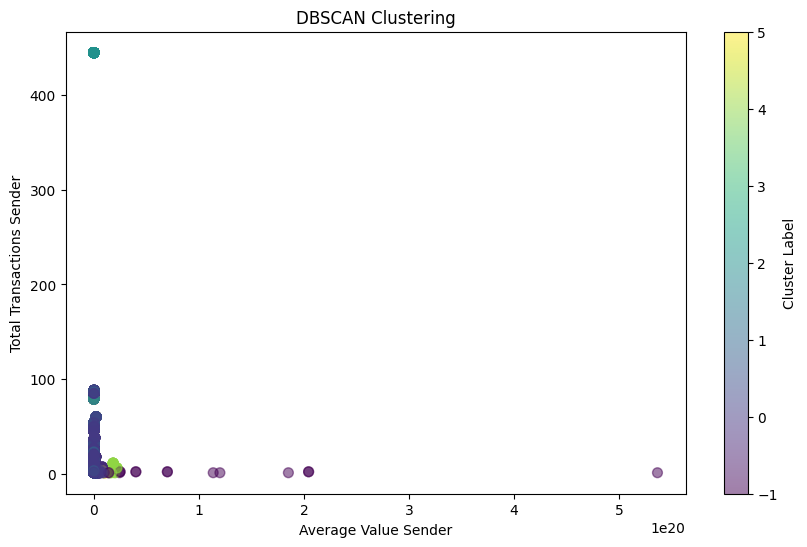

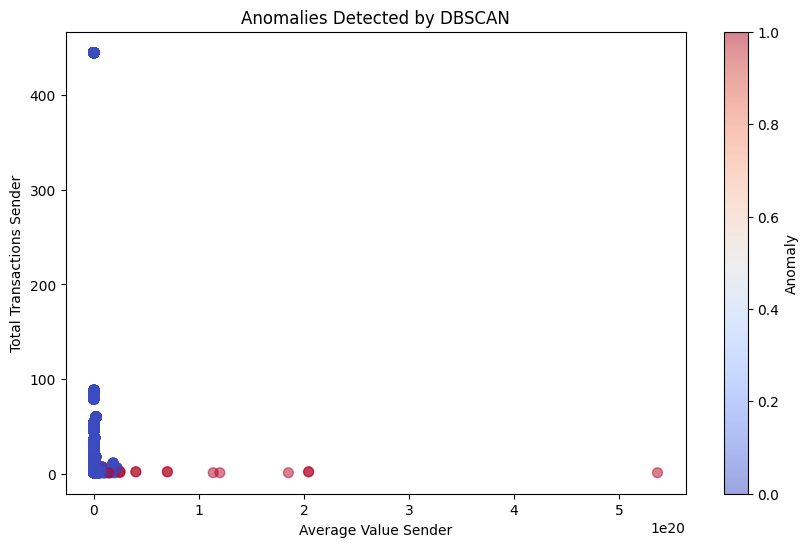

In [53]:
# Visualizing the clusters
plt.figure(figsize=(10, 6))
plt.scatter(features['average_value_sender'], features['total_transactions_sender'], c=labels_dbscan, cmap='viridis', s=50, alpha=0.5)
plt.title('DBSCAN Clustering')
plt.xlabel('Average Value Sender')
plt.ylabel('Total Transactions Sender')
plt.colorbar(label='Cluster Label')
plt.show()

# Visualizing the anomalies
plt.figure(figsize=(10, 6))
plt.scatter(features['average_value_sender'], features['total_transactions_sender'], c=anomalies_dbscan, cmap='coolwarm', s=50, alpha=0.5)
plt.title('Anomalies Detected by DBSCAN')
plt.xlabel('Average Value Sender')
plt.ylabel('Total Transactions Sender')
plt.colorbar(label='Anomaly')
plt.show()


n this example, the anomalies are defined as the points which are in the top 5% of distances from the cluster center. The choice of the threshold and the number of clusters (k) should be tailored to your specific dataset and the nature of the anomalies you expect to find.

# Analyzing All Algotithm's Results
# Columns where all agree are true

In [59]:
allAlgorithmsAgreeAnomaly = df[(df['anomaly'] == True) & (df['anomaly_iso'] == True) & (df['anomaly_dbscan'] == True)][["anomaly_iso","anomaly","anomaly_dbscan"]]

In [60]:
allAlgorithmsAgreeAnomaly

,anomaly_iso,anomaly,anomaly_dbscan
19,True,True,True
239,True,True,True
476,True,True,True
644,True,True,True
1428,True,True,True
3208,True,True,True
3499,True,True,True
3580,True,True,True
3770,True,True,True
3903,True,True,True


# Columns where at least on of them is true

In [57]:
atLeastOneisAnomaly = df[(df['anomaly'] == True) | (df['anomaly_iso'] == True) | (df['anomaly_dbscan'] == True)][["anomaly_iso","anomaly","anomaly_dbscan"]]

# Columns where all agree that are normal

In [58]:
df[(df['anomaly'] == False) & (df['anomaly_iso'] == False) & (df['anomaly_dbscan'] == False)][["anomaly_iso","anomaly","anomaly_dbscan"]]

,anomaly_iso,anomaly,anomaly_dbscan
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
5,False,False,False
...,...,...,...
9994,False,False,False
9995,False,False,False
9996,False,False,False
9997,False,False,False


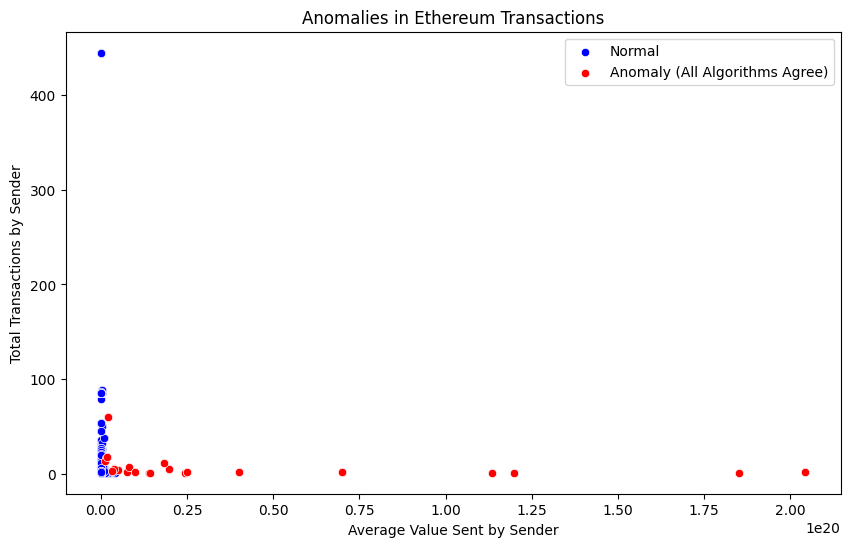

In [62]:
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plotting non-anomalous data
sns.scatterplot(data=df[(df['anomaly'] == False) & 
                        (df['anomaly_iso'] == False) & 
                        (df['anomaly_dbscan'] == False)], 
                x='average_value_sender', 
                y='total_transactions_sender', 
                color='blue', 
                label='Normal')

# Plotting anomalous data detected by all algorithms
sns.scatterplot(data=df[(df['anomaly'] == True) & 
                        (df['anomaly_iso'] == True) & 
                        (df['anomaly_dbscan'] == True)], 
                x='average_value_sender', 
                y='total_transactions_sender', 
                color='red', 
                label='Anomaly (All Algorithms Agree)')

# Anomalies where algorithms disagree
# Plotting anomalies detected by any algorithm
# sns.scatterplot(data=df[(df['anomaly'] != True) & 
#                         (df['anomaly_iso'] != True) & 
#                         (df['anomaly_dbscan'] != True)], 
#                 x='average_value_sender', 
#                 y='total_transactions_sender', 
#                 color='orange', 
#                 label='Anomaly (Disagreement)')

plt.title('Anomalies in Ethereum Transactions')
plt.xlabel('Average Value Sent by Sender')
plt.ylabel('Total Transactions by Sender')
plt.legend()
plt.show()


This visualization will help you quickly identify how anomalies differ in characteristics from normal data points. Remember to adjust the x and y-axis labels to match the features you're most interested in exploring.

# Who are these addreses

In [67]:
anomalous_transactions = df[(df['anomaly'] == True) & 
                             (df['anomaly_iso'] == True) & 
                             (df['anomaly_dbscan'] == True)]

sender_addresses = anomalous_transactions['from_address'].unique()
receiver_addresses = anomalous_transactions['to_address'].unique()

print("Anomalous sender addresses:\n", sender_addresses)
print("\n")
print("Anomalous receiver addresses:\n", receiver_addresses)

Anomalous sender addresses:
 ['0x86ce119ccebcc254d62c335c97afe1ba2a697aef'
 '0xa2e1aa5f8f9f04718a910404efef3d68399efa4d'
 '0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0'
 '0x2211ed0f73daa4c97b403dd12b7e28da59852dac'
 '0x6fc48de8f167456b7aa27dd4ecfabba329ea623d'
 '0x56eddb7aa87536c09ccc2793473599fd21a8b17f'
 '0x849f5236804c52274064a8e65d92e11b3a1cec1a'
 '0x60dc740cd5cf4f5087f6cf1aeecf8c3c698ff4b7'
 '0xf51cd688b8744b1bfd2fba70d050de85ec4fb9fb'
 '0x235d46be238bd8fdd3d20fff883ce69e9fecfcb1'
 '0x78e83b0e05fa3c8caa5d589fd35b1dabdf1edd91'
 '0x7a749b759d8e9e9f34433994868fb035217ab65d'
 '0xc4d976f5884d2d61ad889d9fbe8ce5cd78aa7d65'
 '0xc616a9fe0fa9bf90e74eaf10fe1a73512c8f6c08'
 '0x963737c550e70ffe4d59464542a28604edb2ef9a'
 '0x077d360f11d220e4d5d831430c81c26c9be7c4a4'
 '0x7974b46e7940de2c4d6458c053bdbac0bf111683'
 '0xea27b84e2e684d1574638671de1bbe915d6ec1e3'
 '0xcad621da75a66c7a8f4ff86d30a2bf981bfc8fdd'
 '0x6c8ee01f1f8b62e987b3d18f6f28b22a0ada755f'
 '0x3090399d433df3e6b6281500f22a3b16f6bad8df'
 '0x2

# Evaluation of the  Algorithms

In [71]:
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'df' is your DataFrame and the features are selected
features = df[['hour_of_day', 'day_of_week', 'month', 'year', 'total_transactions_sender', 'total_transactions_receiver', 'average_value_sender', 'average_value_receiver']]

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features.fillna(0))  # Handling nulls by replacing them with 0
y = df['anomaly']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan_test = dbscan.fit_predict(X_test)
anomalies_dbscan_test = labels_dbscan_test == -1

# Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05)
anomalies_iso_test = iso_forest.fit_predict(X_test) == -1

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
anomalies_knn_test = knn.predict(X_test)

# Evaluation
print("DBSCAN Classification Report:")
print(classification_report(y_test, anomalies_dbscan_test))

print("Isolation Forest Classification Report:")
print(classification_report(y_test, anomalies_iso_test))

print("KNN Classification Report:")
print(classification_report(y_test, anomalies_knn_test))


DBSCAN Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      1908
        True       1.00      0.21      0.34        92

    accuracy                           0.96      2000
   macro avg       0.98      0.60      0.66      2000
weighted avg       0.96      0.96      0.95      2000

Isolation Forest Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.98      0.98      1908
        True       0.49      0.41      0.45        92

    accuracy                           0.95      2000
   macro avg       0.73      0.70      0.71      2000
weighted avg       0.95      0.95      0.95      2000

KNN Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1908
        True       0.98      0.99      0.98        92

    accuracy                           1.00      2000
   macro avg       0.99      0.

DBSCAN:

DBSCAN achieves a high precision for anomaly detection, meaning that when it flags a transaction as anomalous, it's usually correct. However, it has a relatively low recall, indicating that it misses many true anomalies.
The overall accuracy and f1-score are decent, but the low recall suggests that DBSCAN may not be capturing all anomalies effectively.

Isolation Forest:

Isolation Forest shows improvement over DBSCAN in terms of recall, capturing a higher proportion of true anomalies. However, its precision is moderate, indicating that some of the transactions flagged as anomalies may be false positives.
The overall accuracy and f1-score are comparable to DBSCAN, but there's room for improvement, especially in precision and recall.

KNN:

KNN performs exceptionally well in all aspects, achieving high precision, recall, accuracy, and f1-score for anomaly detection.
It shows almost perfect performance with very few false positives and false negatives.

Given these results, KNN appears to be the best-performing algorithm for this particular anomaly detection task. It provides the highest precision, recall, and overall accuracy among the three algorithms evaluated. If computational efficiency and interpretability are not significant concerns, KNN would be the preferred choice for anomaly detection in this scenario.

# Let's visualise the best algorithms results

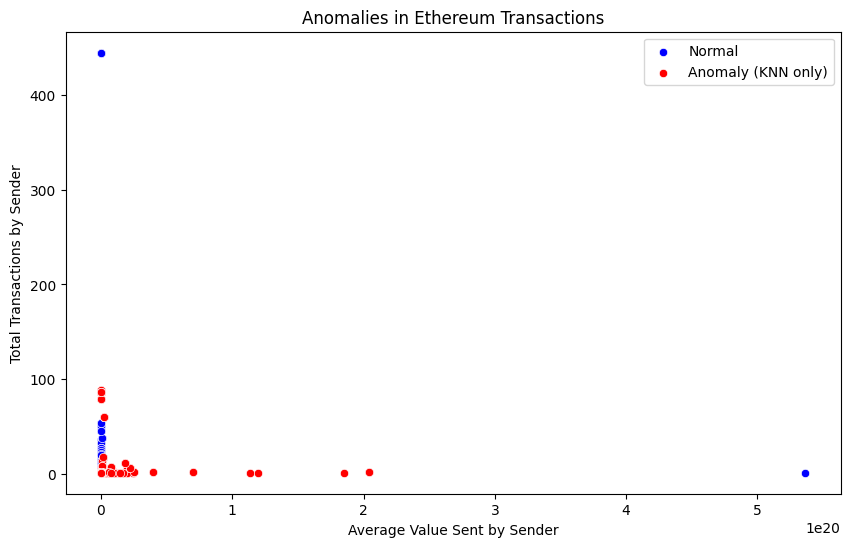

In [74]:
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plotting non-anomalous data
sns.scatterplot(data=df[(df['anomaly'] == False)], 
                x='average_value_sender', 
                y='total_transactions_sender', 
                color='blue', 
                label='Normal')

# Plotting anomalous data detected by all algorithms
sns.scatterplot(data=df[(df['anomaly'] == True)], 
                x='average_value_sender', 
                y='total_transactions_sender', 
                color='red', 
                label='Anomaly (KNN only)')

plt.title('Anomalies in Ethereum Transactions')
plt.xlabel('Average Value Sent by Sender')
plt.ylabel('Total Transactions by Sender')
plt.legend()
plt.show()


# We can check addreses on etherscan

In [75]:
print("Anomalous receiver addresses:\n", receiver_addresses)

Anomalous receiver addresses:
 ['0x86afef8d914f83722139dc0a9f557186fada02ce'
 '0xdac17f958d2ee523a2206206994597c13d831ec7'
 '0x10d0afff7c560d5b41133fff462f0b4932bd9b94'
 '0x943319b22490f93555c53f72f3aa9e31219d99f4'
 '0x7ea871c9343df09034ec580f63ae56118ab8dd48'
 '0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45'
 '0xb1ed4a9662fd2ccee652ba266c847088b67087f8'
 '0x7492e30d60d96c58ed0f0dc2fe536098c620c4c0'
 '0xa69f2992fd68ee984feefaad96e38e577875163b'
 '0x52f21fceacd9e35ad6d782c9ecdeacb4a4919e6e'
 '0x0016c0d0343e8f2c3a7b6a51606b84b1545ec606'
 '0x849f5236804c52274064a8e65d92e11b3a1cec1a'
 '0x0f883c49bb298451a4225ca325997e529c864938'
 '0xb17fe9f5a2b3e016c653e101845121421e2b225a'
 '0x0d095a0b3b89621508a520c15388ace20599ce68'
 '0xd08a5966ace848363950ffe1795a2c411b654f8c'
 '0x970e24aa00befcdf0ad09178312ff450016caf66'
 '0xa17f554d5fe8cf337875b264f882e5e62228ec55'
 '0x221e675d25321b3fa1574401cf8ad5483b11af98'
 '0xc36442b4a4522e871399cd717abdd847ab11fe88'
 '0xb89dc6ded140bd68d08cd29f5092c25d05fad6e9'
 '0

In [147]:
# Saving Data
# df.to_csv("./eth_transactions_clustered.csv", index=False)